In [1]:
import pandas as pd

Running the following on BQ:
```
"""
SELECT DAYOFYEAR(timestamp) as day,
       COUNT(DAYOFYEAR(timestamp)) as total_downloads,
       REGEXP_EXTRACT(details.python, r'^(\d+)') as details_python,
       REGEXP_EXTRACT(details.installer.version, r'^(\d+)') as iv,
       REGEXP_EXTRACT(file.version, r'^(\d+).\d+.\d+$') as version, 
       details.installer.name,
       file.project
FROM (TABLE_DATE_RANGE([the-psf:pypi.downloads], 
                TIMESTAMP('2017-04-10'), 
                TIMESTAMP('2017-05-15')))
WHERE file.project IN ('ipython', 'pip' )
AND file.version in ('6.0.0', '9.0.1', '5.3.0')
AND details.installer.name == 'pip'
GROUP BY day, details_python,iv, details.installer.name, file.project, version
ORDER BY day
"""
```

In [2]:
df = pd.read_csv('~/Downloads/results-20170515-202058.csv')
df['details_python'] = df['details_python'].fillna(0.0).astype(int)
df.tail()

,day,total_downloads,details_python,iv,version,details_installer_name,file_project
1034,135,9992,3,8,9,pip,pip
1035,135,2604,3,7,9,pip,pip
1036,135,60,3,8,5,pip,ipython
1037,135,10,3,1,5,pip,ipython
1038,135,699,3,8,6,pip,ipython


In [3]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
plt.ion()
figsize(10,3)

In [4]:
df_to_plot_ipython5 = (df.where(df['file_project'] == 'ipython')
              .where((df['iv'] > 8) & (df['iv'] < 10))
              .where(df['version'] == 5)
              .drop('version',1)
              .dropna(how='all'))
df_to_plot_ipython5['iv'] = df_to_plot_ipython5['iv'].astype(int)
df_to_plot_ipython5['details_python'] = df_to_plot_ipython5['details_python'].astype(int)

ipython5_pivot = pd.pivot_table(df_to_plot_ipython5,
                    index=['day'],
                    columns=['details_python', 'iv'],
)

In [5]:
df_to_plot_ipython6 = (df
                       .where(df['file_project'] == 'ipython')
                       .where((df['iv'] > 7) & (df['iv'] < 10))
                       .where(df['version'] == 6)
                       .where(((df['iv']==8)&(df['details_python']==2))|
                              ((df['iv']==9)&(df['details_python']==3)))
                       .drop('version',1)
                       .dropna(how='all')
                      )
df_to_plot_ipython6['iv'] = df_to_plot_ipython6['iv'].astype(int)
df_to_plot_ipython6['details_python'] = df_to_plot_ipython6['details_python'].astype(int)

ipython6_pivot = pd.pivot_table(df_to_plot_ipython6, 
                                index=['day'], 
                                columns=['details_python', 'iv']) 

# Plotting

In [6]:
release_day = 110
global_ylim = 19900
ylabel_dict = {
    'ylabel': 'Total Downloads',
    'fontsize': 'large'
}

xlabel_dict = {
    'xlabel': 'Days',
    'fontsize': 'large'
}


title_template = "Downloads of IPython {}"
legend_format = {
    "frameon": False,
    "fontsize": 'large'
}
release_day_line_format = {
    "linestyle": '--',
    "color": 'k',
    "alpha": 0.5
}
title_format = {
    'fontdict':{
        'fontsize': 'x-large',
    }
}



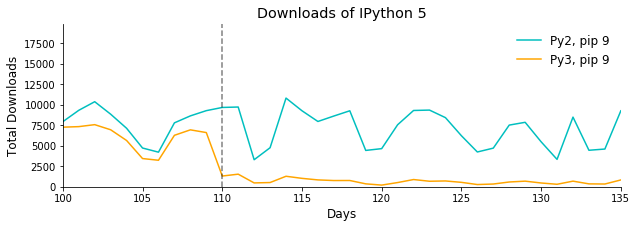

In [7]:
fig_ipython5, ipython5_ax = plt.subplots()
ipython5_pivot.plot(title=title_template.format(5),
                    ax=ipython5_ax,
                    color=['c','orange']
                    )
ipython5_ax.set_title(ipython5_ax.get_title(), **title_format)
ipython5_ax.axvline(release_day, **release_day_line_format)
ipython5_ax.spines['right'].set_visible(False)
ipython5_ax.spines['top'].set_visible(False)
ipython5_ax.set_ylim(0,global_ylim)
ipython5_ax.set_ylabel(**ylabel_dict)
ipython5_ax.set_xlabel(**xlabel_dict)
ipython5_ax.legend(labels=['Py2, pip 9','Py3, pip 9'], **legend_format)

fig_ipython5.savefig('ipython5_dl.png', bbox_inches='tight')

Download of IPython 5 - 9, on Python 2 and Python 3. We see the 2 lower curves are the downloads of IPython 5 using pip 8 both on Python 2 and Python 3. At day 110 we see a clear decrease in pip 8  download.

It make sense for python 2 - pip install with pip 8 breaks, and ask users to upgrade. 
The Python 3 is more surprising. – this is likely due to the blog post annouce that explicitely warn to update pip before upgrading IPython. 

User do listen :-) even user on IPython 5. 

The red curve show a sharp decrease of IPython 5 download with pip-9 on Python 3. These are users upgrading to IPython 6. 

The red curve noise level are explicit installs, and pinned versions I guess.

The Orange Curve is the sustained install of IPython 5 for pip-9 users, these will likely not even realize we did release a new version. 

So far:  Mission accomplished.

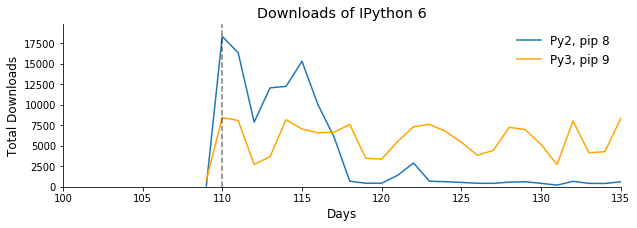

In [8]:
fig_ipython6, ipython6_ax = plt.subplots()
ipython6_pivot.plot(title=title_template.format(6), color=['C0','orange'], ax = ipython6_ax)

ipython6_ax.set_title(ipython6_ax.get_title(), **title_format)
ipython6_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython6_ax.spines['right'].set_visible(False)
ipython6_ax.spines['top'].set_visible(False)
ipython6_ax.set_ylabel(**ylabel_dict)
ipython6_ax.set_xlabel(**xlabel_dict)
ipython6_ax.set_xlim(100);
ipython6_ax.set_ylim(0,global_ylim)
ipython6_ax.legend(labels=['Py2, pip 8','Py3, pip 9'], **legend_format)

fig_ipython6.savefig('ipython6_dl.png', bbox_inches='tight')

The orange curve is the sustained download of IPython 6 with pip 9 on Python 3. 

The blue curve are the – appology to them – Python 2 users with pip 8, for which the installation fails, and get presented with a nice error message asking to upgrade pip. 
These have either upgraded pip to pip 9, or pinned ipython's version. 

If they updated pip you should (?) see an increase of download in IPython 5.x – though we have no new release, maybe we should have released 5.4 at the same time ?

In [9]:
figsize(10,6)

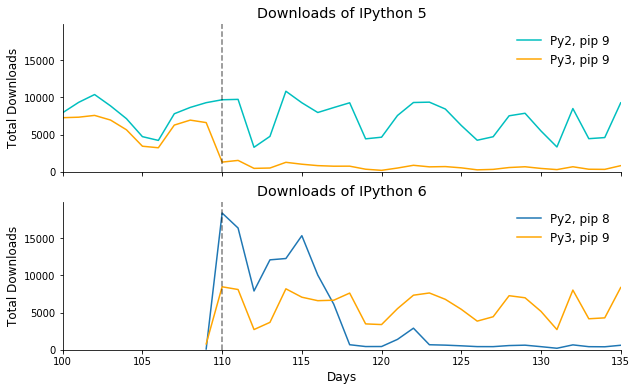

In [10]:
fig, (ipython5_ax, ipython6_ax) = plt.subplots(2, 1, sharex=True)


# set all the ipython5 bits

ipython5_pivot.plot(title=title_template.format(5), color=['c','orange'], ax=ipython5_ax)

ipython5_ax.set_title(ipython5_ax.get_title(), **title_format)
ipython5_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython5_ax.spines['right'].set_visible(False)
ipython5_ax.spines['top'].set_visible(False)
ipython5_ax.set_ylim(0,global_ylim)
ipython5_ax.set_ylabel(**ylabel_dict)
ipython5_ax.set_xlabel(**xlabel_dict)
ipython5_ax.legend(labels=['Py2, pip 9','Py3, pip 9'], **legend_format)

# set all the ipython6 bits
ipython6_pivot.plot(title=title_template.format(6), color=['C0','orange'], ax = ipython6_ax)

ipython6_ax.set_title(ipython6_ax.get_title(), **title_format)
ipython6_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython6_ax.spines['right'].set_visible(False)
ipython6_ax.spines['top'].set_visible(False)
ipython6_ax.set_ylabel(**ylabel_dict)
ipython6_ax.set_xlabel(**xlabel_dict)
ipython6_ax.set_xlim(100);
ipython6_ax.set_ylim(0,global_ylim)
ipython6_ax.legend(labels=['Py2, pip 8','Py3, pip 9'], **legend_format)

# saving figure
fig.savefig('combined_ipython_graphs.png', bbox_inches='tight')